# Experimenting with Maximum Likelihood Parameter Estimation (MLE)
Ball drop air

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.integrate import odeint

## Generate data for a ball drop

In [2]:
def calculate_force(g, m, cd, u):
    return g*m - cd*u**2
    
def calculate_acceleration(g, cd, m, u):
    return calculate_force(g=g, m=m, cd=cd, u=u)/m

def ball_drop_air(states, t, g, m, cd):
    
    # states:
    # [x,u]
        
    x = states[0]
    u = states[1]
    dxdt = u
    
    dudt = calculate_acceleration(g=g, cd=cd, m=m, u=u)
    
    d_states_dt = np.array([dxdt,dudt])
    
    return d_states_dt

In [3]:
calculate_force(g=9.81, m=2,cd=0.01,u=5)

19.37

In [4]:
calculate_acceleration(g=9.81, m=2,cd=0.01,u=5)

9.685

In [5]:
def simulate(states_0, t, g, m, cd):
    states = odeint(func = ball_drop_air,y0 = states_0,t = t,args=(g,m,cd))
    return states

In [6]:
states_0 = np.array([0,0])
t = np.linspace(0,10,100)
g=9.81
m = 1
cd = 0.01
states = simulate(states_0=states_0,t = t, g=g, m=m, cd=cd)

In [7]:
x = states[:,0]
dxdt = states[:,1]

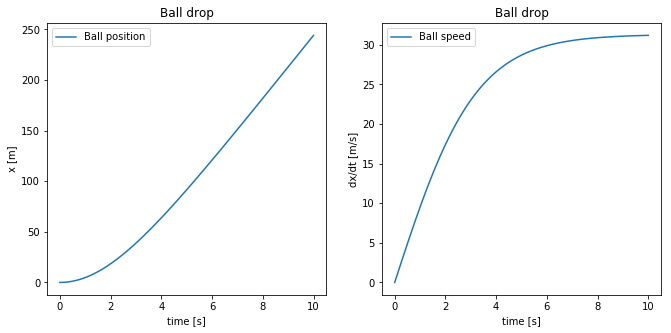

In [8]:
fig,axes = plt.subplots(ncols = 2)
fig.set_size_inches(11,5)
ax = axes[0]
ax.plot(t,x,label = 'Ball position')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
a = ax.legend()

ax = axes[1]
ax.plot(t,dxdt,label = 'Ball speed')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('dx/dt [m/s]')
a = ax.legend()

## Add measurement noice

In [9]:
ϵ = np.random.normal(loc = 0.0, scale = 4.0, size = len(x))
x_measure = x + ϵ

In [10]:
v_measure = np.gradient(x_measure,t)
a_measure = np.gradient(v_measure,t)

In [11]:
df = pd.DataFrame({'t':t, 'x':x_measure, 'v':v_measure, 'a':a_measure})

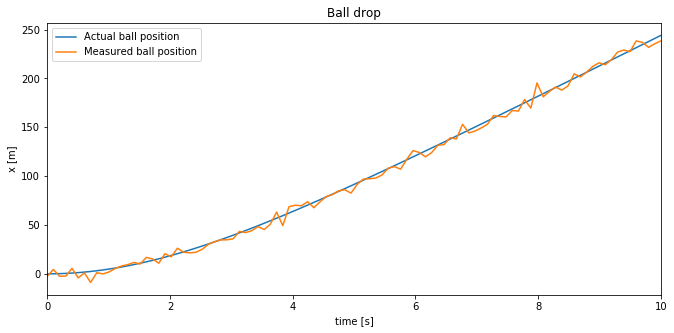

In [12]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
ax.plot(t,x, label = 'Actual ball position')
df.plot(x='t', y='x', label = 'Measured ball position', ax=ax)
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()

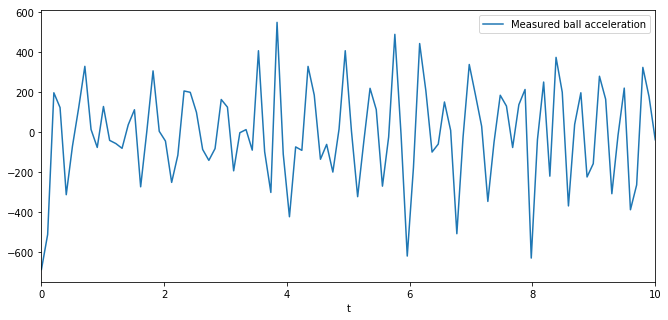

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
df.plot(x='t', y='a', ax=ax, label='Measured ball acceleration')

## Maximum Likelihood 

In [14]:
def MLERegression2(params,m):
    
    v_0, a_0, g, cd, std = params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    states_0 = [v_0, a_0]
    states = simulate(states_0, t=t, g=g, m=m, cd=cd)
    xhat = states[:,0]
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(x_measure, loc=xhat, scale=std) )
    # return negative LL
    return(negLL)

In [15]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([0, 0, 5, 10, 0.1])
results = minimize(MLERegression2, guess, method = 'Nelder-Mead', 
          options={'disp': True},args=(m,))

c:\dev\rolldecay\venv\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [16]:
results

 final_simplex: (array([[-1.15376442e+00, -7.22567201e-01,  9.39241397e+01,
        -7.73885743e+03,  1.13509949e+02],
       [-1.15376442e+00, -7.22567201e-01,  9.39241397e+01,
        -7.73885743e+03,  1.13509949e+02],
       [-1.15376442e+00, -7.22567201e-01,  9.39241397e+01,
        -7.73885743e+03,  1.13509949e+02],
       [-1.15376442e+00, -7.22567201e-01,  9.39241397e+01,
        -7.73885743e+03,  1.13509949e+02],
       [-1.15376442e+00, -7.22567201e-01,  9.39241397e+01,
        -7.73885743e+03,  1.13509949e+02],
       [-1.15376442e+00, -7.22567201e-01,  9.39241397e+01,
        -7.73885743e+03,  1.13509949e+02]]), array([615.08940725, 628.13053515, 628.13053515, 628.13053515,
       628.13053515, 628.13053515]))
           fun: 615.0894072517009
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1004
           nit: 364
        status: 1
       success: False
             x: array([-1.15376442e+00, -7.22567201e-01,  9.39241397e+01, -7.7

In [17]:
coefficients = results['x']

In [18]:
states_0_pred = coefficients[0:2]
g_pred = coefficients[2]
cd_pred = coefficients[3]

states_pred = simulate(states_0=states_0_pred,t = t, g=g_pred, cd=cd_pred, m=m)
x_pred = states_pred[:,0]
v_pred = states_pred[:,1]


In [19]:
g_pred

93.9241396762556

In [20]:
cd_pred

-7738.857433655146

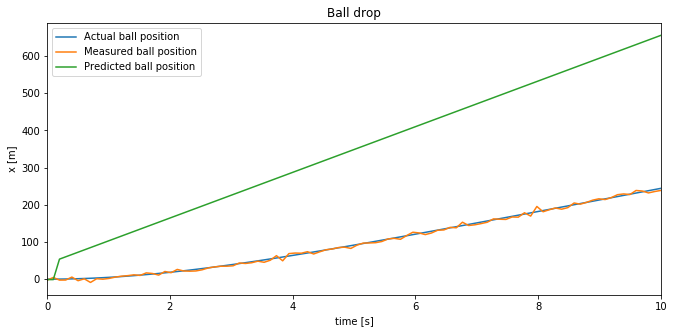

In [21]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
ax.plot(t,x, label = 'Actual ball position')
df.plot(x='t', y='x', label = 'Measured ball position', ax=ax)
ax.plot(t,x_pred, label = 'Predicted ball position')
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()